### ***Exploratory Data Analysis: ANZ Synthesized 3-month Transactional Dataset***

### **Background**
**Source** : *https://www.theforage.com/modules/ZLJCsrpkHo9pZBJNY/BiJPfqmGY2QwgN6gA*

<sup>This task is based on a synthesised transaction dataset containing 3 months’ worth of transactions for 100 hypothetical customers. It contains purchases, recurring transactions, and salary transactions. The dataset is designed to simulate realistic transaction behaviours that are observed in ANZ’s real transaction data, so many of the insights gathered from the activities will be genuine.</sup>


### ***STEP 0: LOADING THE DATASET***

In [86]:
!pip install geopandas

In [87]:
# These are the necessary Python libraries to perform EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from wordcloud import WordCloud

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

In [88]:
import os 
df=pd.read_excel("/content/drive/MyDrive/ANZ/ANZ synthesised transaction dataset.xlsx")

In [89]:
df.head()

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement
0,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,35.39,2018-08-01,F,26.0,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.38 -27.99,debit
1,authorized,0.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,21.20,2018-08-01,F,26.0,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,151.21 -33.87,debit
2,authorized,1.0,NaN,ACC-1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,NaN,Michael,5.71,2018-08-01,M,38.0,Sydney,NSW,2018-08-01T01:26:15.000+0000,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,CUS-2142601169,151.21 -33.87,debit
3,authorized,1.0,NaN,ACC-1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,NaN,Rhonda,2117.22,2018-08-01,F,40.0,Buderim,QLD,2018-08-01T01:38:45.000+0000,40.90,2698170da3704fd981b15e64a006079e,Australia,CUS-1614226872,153.05 -26.68,debit
4,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,NaN,Diana,17.95,2018-08-01,F,26.0,Mermaid Beach,QLD,2018-08-01T01:51:15.000+0000,3.25,329adf79878c4cf0aeb4188b4691c266,Australia,CUS-2487424745,153.44 -28.06,debit


In [90]:
df.shape

(12043, 23)

In [91]:
df.columns

Index(['status', 'card_present_flag', 'bpay_biller_code', 'account',
       'currency', 'long_lat', 'txn_description', 'merchant_id',
       'merchant_code', 'first_name', 'balance', 'date', 'gender', 'age',
       'merchant_suburb', 'merchant_state', 'extraction', 'amount',
       'transaction_id', 'country', 'customer_id', 'merchant_long_lat',
       'movement'],
      dtype='object')

In [92]:
df.nunique()

status                   2
card_present_flag        2
bpay_biller_code         3
account                100
currency                 1
long_lat               100
txn_description          6
merchant_id           5725
merchant_code            1
first_name              80
balance              12006
date                    91
gender                   2
age                     33
merchant_suburb       1609
merchant_state           8
extraction            9442
amount                4457
transaction_id       12043
country                  1
customer_id            100
merchant_long_lat     2703
movement                 2
dtype: int64

In [93]:
df.dtypes

status                       object
card_present_flag           float64
bpay_biller_code             object
account                      object
currency                     object
long_lat                     object
txn_description              object
merchant_id                  object
merchant_code               float64
first_name                   object
balance                     float64
date                 datetime64[ns]
gender                       object
age                         float64
merchant_suburb              object
merchant_state               object
extraction                   object
amount                      float64
transaction_id               object
country                      object
customer_id                  object
merchant_long_lat            object
movement                     object
dtype: object

### ***Step 1: Data Wrangling***

* *It is important that data can be parsed for a variety of 
downstream purposes.* 
* *The data below will be converted into the appropriate data types for assuring data quality and usefulness.*
* *The guidelines for the conversion are laid out in the data dictionary. Please refer to readme.md file.*



#### **Dealing with missing values**

In [94]:
# display all missing values
df.isna().sum()

status                   0
card_present_flag     4326
bpay_biller_code     11158
account                  0
currency                 0
long_lat                 0
txn_description          0
merchant_id           4326
merchant_code        11160
first_name               0
balance                  0
date                     0
gender                   0
age                      0
merchant_suburb       4326
merchant_state        4326
extraction               0
amount                   0
transaction_id           0
country                  0
customer_id              0
merchant_long_lat     4326
movement                 0
dtype: int64

In [95]:
# filling missing columns with 0
#df.fillna(0, inplace=True)

In [96]:
# check if all missing values have been replaced
df.isna().sum()

status                   0
card_present_flag     4326
bpay_biller_code     11158
account                  0
currency                 0
long_lat                 0
txn_description          0
merchant_id           4326
merchant_code        11160
first_name               0
balance                  0
date                     0
gender                   0
age                      0
merchant_suburb       4326
merchant_state        4326
extraction               0
amount                   0
transaction_id           0
country                  0
customer_id              0
merchant_long_lat     4326
movement                 0
dtype: int64

In [97]:
df.duplicated().sum()

0

#### ***Data Cleaning***

In [98]:
# these are the unique values in the status column.
df['status'].value_counts()

authorized    7717
posted        4326
Name: status, dtype: int64

In [99]:
# all the transactions happened in Australia.
df['country'].value_counts()

Australia    12043
Name: country, dtype: int64

In [100]:
# the unique movement types 
df.movement.value_counts()

debit     11160
credit      883
Name: movement, dtype: int64

In [101]:
# I am going to change the dtype of date column and extraction column to datetime.
df['date'] = pd.to_datetime(df['date'])
df['extraction'] = pd.to_datetime(df['extraction'])

In [102]:
# adding three columns: year, month, and day of the transaction to make the segmentation by date easy.
df['day']= df['date'].dt.day_name()
df['month'] = df['date'].dt.month_name()
df['year'] = df['date'].dt.year

In [103]:
# now let's check the unique values of our new columns
df.year.value_counts()

2018    12043
Name: year, dtype: int64

In [104]:
# because all the transactions are from 2018, I will drop the year columns
df.drop(['year'], axis = 1 , inplace = True)

In [105]:
# it looks like transactions happened only in August, September, and October
df.month.value_counts()

October      4087
September    4013
August       3943
Name: month, dtype: int64

In [106]:
# unique values of txn_description (mode of transaction)
df.txn_description.value_counts()

SALES-POS     3934
POS           3783
PAYMENT       2600
PAY/SALARY     883
INTER BANK     742
PHONE BANK     101
Name: txn_description, dtype: int64

In [107]:
# finally let's check the distribution of the dataset by gender
df.gender.value_counts()

M    6285
F    5758
Name: gender, dtype: int64

#### ***Data type conversion***

In [108]:
# convert status into categorical data type
s = pd.CategoricalDtype(categories=['authorized', 'posted'], ordered=True)
df.status = df.status.astype(s)

In [109]:
# convert card_present_cat into category data type with values 1 and 0
cpc = pd.CategoricalDtype(categories=[1, 0], ordered=True)
df.card_present_flag = df.card_present_flag.astype(cpc)

In [110]:
# convert gender into category data type with values M and F
g = pd.CategoricalDtype(categories=['M', 'F'], ordered=True)
df.gender = df.gender.astype(g)

In [111]:
# convert age into int32 data type
df.age = df.age.astype('int32')

In [112]:
# convert txn_description field into category data type
td = pd.CategoricalDtype(categories=['POS','SALES-POS','PAYMENT','INTER BANK','PAY/SALARY','PHONE BANK'], ordered=True)
df.txn_description = df.txn_description.astype(td)

In [113]:
# Create new feature for card present flag in Boolean terms
b = pd.BooleanDtype()
df['card_present_bool'] = df.card_present_flag.astype(b)

In [114]:
# check all data types have been converted correctly
df.dtypes

status                          category
card_present_flag               category
bpay_biller_code                  object
account                           object
currency                          object
long_lat                          object
txn_description                 category
merchant_id                       object
merchant_code                    float64
first_name                        object
balance                          float64
date                      datetime64[ns]
gender                          category
age                                int32
merchant_suburb                   object
merchant_state                    object
extraction           datetime64[ns, UTC]
amount                           float64
transaction_id                    object
country                           object
customer_id                       object
merchant_long_lat                 object
movement                          object
day                               object
month           

In [115]:
# print out cleaned data to csv file for Task 2: Predictive Analysis
df.to_csv('/content/drive/MyDrive/ANZ/ANZ-synthesized-transactions-cleaned.csv')

### ***Step 2 : Overview***


> #### *A) What is the average transaction amount?*



In [116]:
# Generate summary statistics for amount
df.amount.describe()

count    12043.000000
mean       187.933588
std        592.599934
min          0.100000
25%         16.000000
50%         29.000000
75%         53.655000
max       8835.980000
Name: amount, dtype: float64


><sup>*From the above summary it suggests that there is a heavy amount of positive skew for this distrbitution. It is also quite excessively leptokurtic on a normal scale, meaning that a log transformation should probably be applied to smooth the distribution.*



In [117]:
# check for skew on untransformed amount data
df.amount.skew()

5.356266394770427

In [118]:
# transform amount series into a log scale
amount_log = np.log(df.amount)
amount_log.skew()

1.4091072595935499


*   *The log transformation managed to reduce skewness from 5.356266394770427 to 1.4091072595935499. As skewness is not 0, the mean is not a very good measure of central tendency.*
*  *Plotting a histogram with seaborn can give a good visualisation of the amounts.*



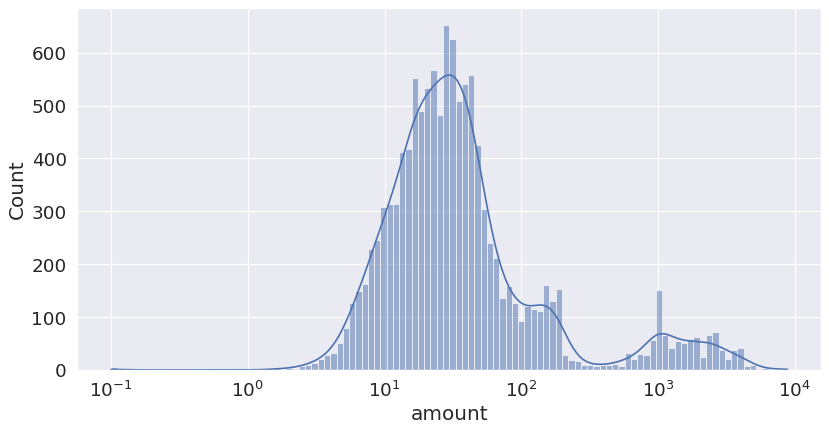

In [119]:
# Make a figure using matplotlib
fig = plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
# set font size in sns
sns.set(font_scale=1.5)
# plot a histogram using an adjusted logscale and probability density curve
sns.histplot(data=df, x='amount', log_scale=True, kde=True)

><SUB>The above logarithmically scaled distribution demonstrates that transactions at small amounts tend to peak very quickly at ~$30 AUD, after decaying gradually up to 
~1000 AUD, it tends to have a slight peak again. The shape of the graph tends to be a little bimodal, suggesting that other variables like income class may be influencing this distribution

In [120]:
# Calculate mean amount
df.amount.mean()

187.93358797641767

In [121]:
# Calculate meadian amount
df.amount.median()

29.0

In [122]:
# Calculate mode amount
df.amount.mode()

0    33.0
dtype: float64

><sub>Since there is a large discrepency between the mean and median, as well as mean and mode. The median seems to be quite an accurate measure of central tendency
Hence the average transaction amount seems to be **$29.00 AUD**

> #### *B. How many transactions do customers make each month, on average?*

In [123]:
# group monthly data by count of values and sort
x=df.month.value_counts().sort_values()
x

August       3943
September    4013
October      4087
Name: month, dtype: int64

> <sup>Above data show that transaction volume has increased steadily over the months

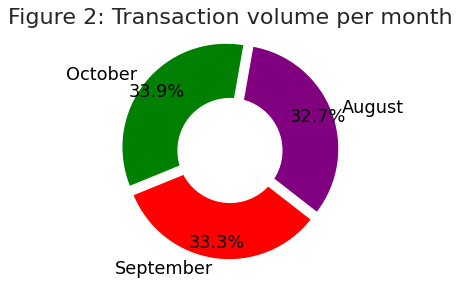

In [124]:
# plot frequency of some observations using pie chart
labels = df.month.value_counts().index
frequency = df.month.value_counts()

# ensure enough spacing between sections for sparse aesthetic
explode = (0.05, 0.05, 0.05)

#add colors
colors = ['green','red','purple']

# Draw pie plot
fig1, ax1 = plt.subplots(figsize=(6,4), dpi=80)
patches, texts, autotexts = ax1.pie(frequency, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=80, pctdistance=0.85, textprops={'fontsize': 16})

# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis('equal')

# add title
plt.title('Figure 2: Transaction volume per month', fontsize=20)

# Make text grey
for text in texts:
    text.set_color('black')
for autotext in autotexts:
    autotext.set_color('black')

# Draw circle to make donut
centre_circle = plt.Circle((0,0),0.50,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Display plot
plt.show()

> <sup>The pie chart above shows that the percentage differences among transactions of the different months are relatively trivial. It is hard to tell the behvaiour of transaction volume in the future due to the insufficient data provided in the dataset.

In [125]:
# Get monthly mean of transaction amounts
x=df.month.value_counts()
print('Monthly mean of transaction amounts: $%.2f' % x.mean())

Monthly mean of transaction amounts: $4014.33


> <sub>On average, customers make aroound 4014.3333333333335 transactions per month based on the data provided

### ***Step 3: Visualization and Insights***

> #### *Transaction volume over dates*

In [126]:
date_group = df.groupby('date')["amount"].sum().reset_index()

In [127]:
date_group.head()

,date,amount
0,2018-08-01,29867.94
1,2018-08-02,21786.32
2,2018-08-03,38096.58
3,2018-08-04,6296.05
4,2018-08-05,4426.50


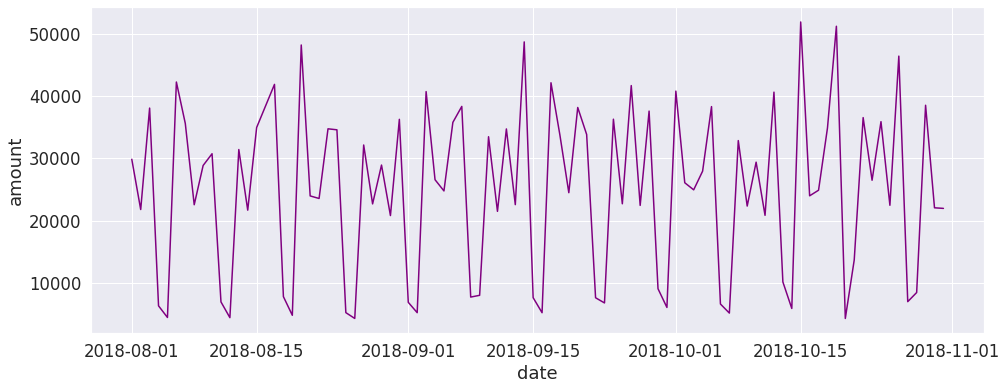

In [128]:
plt.figure(figsize=(16, 6))
sns.lineplot(y="amount",x="date",data=date_group,color='purple')

> ##### *Mean transaction amount per day*

In [129]:
date_mean = df.groupby("date")["amount"].mean().reset_index()

In [130]:
date_mean.head()

,date,amount
0,2018-08-01,218.014161
1,2018-08-02,143.331053
2,2018-08-03,242.653376
3,2018-08-04,53.356356
4,2018-08-05,44.265000


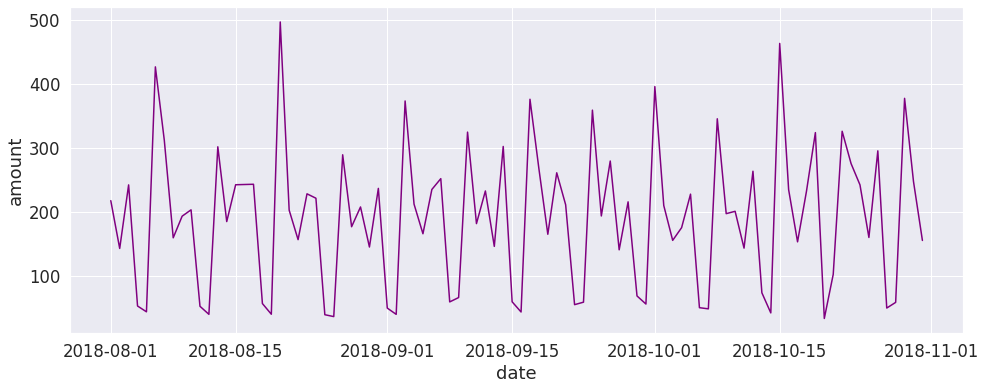

In [131]:
plt.figure(figsize=(16, 6))
sns.lineplot(y="amount",x="date",data=date_mean,color='purple')

> #### *Transaction volume by gender*

In [132]:
gender_vol = df[["date","amount","gender"]]
gender_vol.head()

,date,amount,gender
0,2018-08-01,16.25,F
1,2018-08-01,14.19,F
2,2018-08-01,6.42,M
3,2018-08-01,40.90,F
4,2018-08-01,3.25,F


In [133]:
gender_data = gender_vol.groupby(['date',"gender"])["amount"].sum().reset_index()
gender_data

,date,gender,amount
0,2018-08-01,M,16239.30
1,2018-08-01,F,13628.64
2,2018-08-02,M,15890.07
3,2018-08-02,F,5896.25
4,2018-08-03,M,21004.99
...,...,...,...
177,2018-10-29,F,16429.25
178,2018-10-30,M,11011.09
179,2018-10-30,F,11051.25
180,2018-10-31,M,8262.88


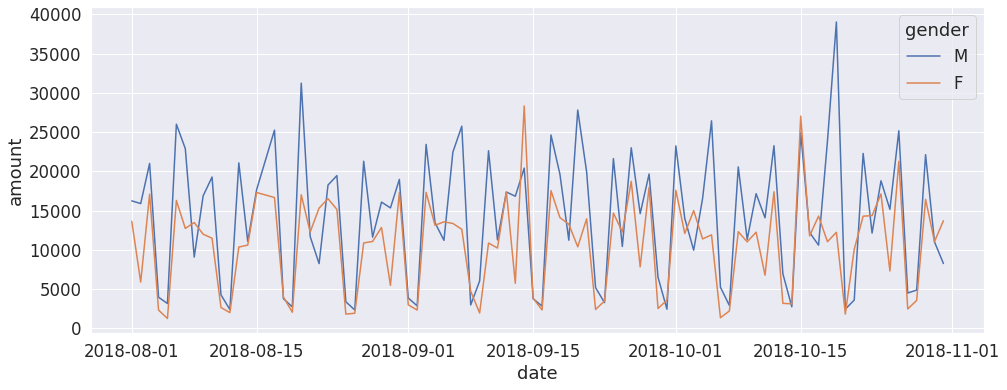

In [134]:
plt.figure(figsize=(16, 6))
sns.lineplot(y="amount",x="date",hue="gender",data=gender_data)

> ##### *Mean transaction by gender*

In [135]:
gender_mean = df.groupby(["date","gender"])["amount"].mean().reset_index()
gender_mean.head()

,date,gender,amount
0,2018-08-01,M,246.050000
1,2018-08-01,F,191.952676
2,2018-08-02,M,191.446627
3,2018-08-02,F,85.452899
4,2018-08-03,M,269.294744


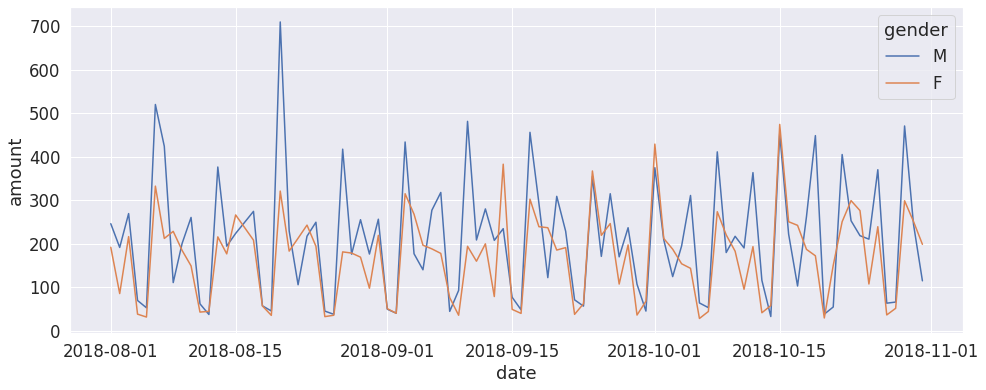

In [136]:
plt.figure(figsize=(16, 6))
sns.lineplot(y="amount",x="date",hue="gender", data=gender_mean)

> #### *Transaction volume by merchant state*

In [137]:
merchant_state_total = df.groupby(["merchant_state","gender"])["amount"].sum().reset_index()
merchant_state_total

,merchant_state,gender,amount
0,ACT,M,3219.24
1,ACT,F,1657.44
2,NSW,M,60590.89
3,NSW,F,41430.88
4,NT,M,427.47
5,NT,F,8741.42
6,QLD,M,24872.40
7,QLD,F,28611.05
8,SA,M,5426.84
9,SA,F,11349.73


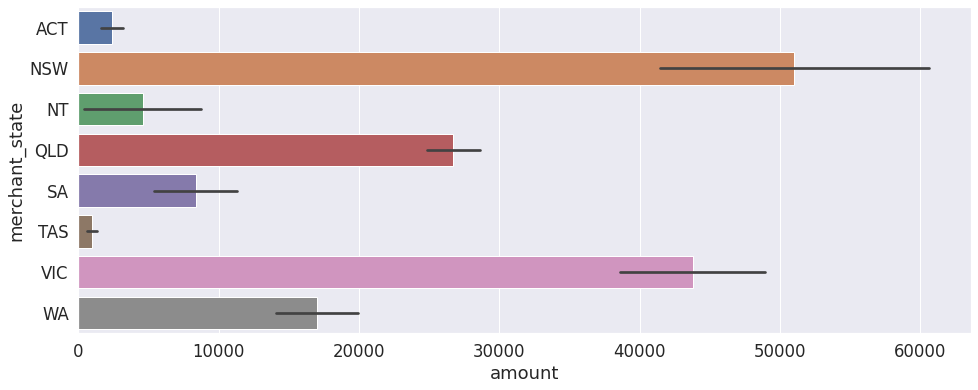

In [138]:
plt.figure(figsize=(16, 6))
sns.barplot(x="amount", y="merchant_state",  data=merchant_state_total)

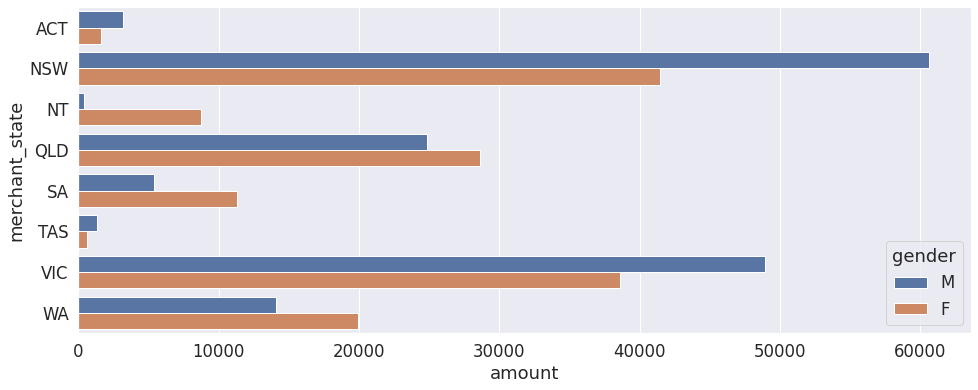

In [139]:
plt.figure(figsize=(16, 6))
sns.barplot(x="amount", y="merchant_state", hue="gender", data=merchant_state_total)

> ##### *Transaction volume by merchant suburb (sum)* 

In [140]:
merchant_suburb= df.groupby(["merchant_suburb"])["amount"].sum().reset_index()
merchant_suburb.head()

,merchant_suburb,amount
0,Abbotsford,2004.29
1,Aberdeen,52.45
2,Aberfeldie,57.77
3,Aberfoyle Park,84.92
4,Acacia Ridge,10.30


In [141]:
suburb_sorted=merchant_suburb.sort_values(by='amount', ascending=False)
print("Top 10 regions with most value of transactions over 91 days are-")
print(suburb_sorted.head(10).values)

Top 10 regions with most value of transactions over 91 days are-
[['Sydney' 21675.44]
 ['Melbourne' 11943.53]
 ['South Brisbane' 11740.58]
 ['Mascot' 10282.62]
 ['Mount Gambier' 4710.25]
 ['Malvern' 3994.8300000000004]
 ['Maribyrnong' 3770.83]
 ['Parap' 3323.5099999999998]
 ['Brisbane City' 2724.45]
 ['Mount Gravatt' 2721.14]]


In [142]:
tuple_suburb_sum = [tuple(x) for x in merchant_suburb.values]

(-0.5, 1399.5, 1199.5, -0.5)

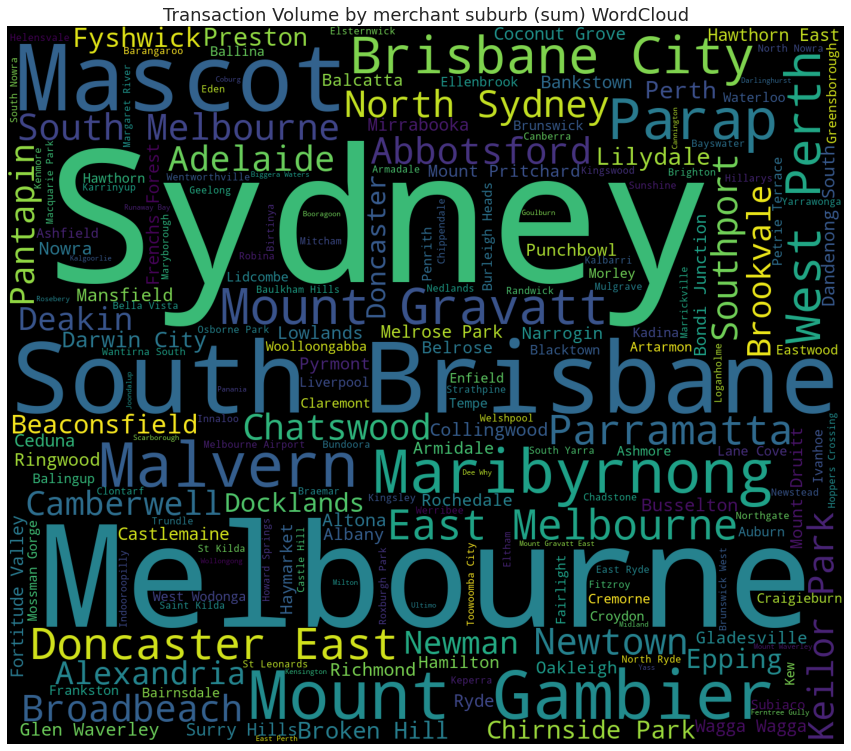

In [143]:
plt.subplots(figsize=(15,15))
wordcloud = WordCloud(width=1400,height=1200).generate_from_frequencies(dict(tuple_suburb_sum))
plt.title('Transaction Volume by merchant suburb (sum) WordCloud')

plt.imshow(wordcloud)
plt.axis("off")

> #### *Transaction volume by merchant suburb (mean)*

In [144]:
merchant_suburb_mean= df.groupby(["merchant_suburb"])["amount"].mean().reset_index()
merchant_suburb_mean.head(5)

,merchant_suburb,amount
0,Abbotsford,400.858
1,Aberdeen,26.225
2,Aberfeldie,57.770
3,Aberfoyle Park,42.460
4,Acacia Ridge,10.300


In [145]:
suburb_sorted_mean=merchant_suburb_mean.sort_values(by='amount', ascending=False)
print("Top 10 regions with most mean value of transactions over 91 days are-")
print(suburb_sorted_mean.head(10).values)

Top 10 regions with most mean value of transactions over 91 days are-
[['Pantapin' 829.7650000000001]
 ['Gladesville' 734.1]
 ['West Wodonga' 559.33]
 ['South Brisbane' 559.0752380952381]
 ['Parap' 553.9183333333333]
 ['Lowlands' 524.58]
 ['Mossman Gorge' 501.67]
 ['Fairlight' 496.76]
 ['Deakin' 491.50666666666666]
 ['Mount Gravatt' 453.5233333333333]]


(-0.5, 1399.5, 1199.5, -0.5)

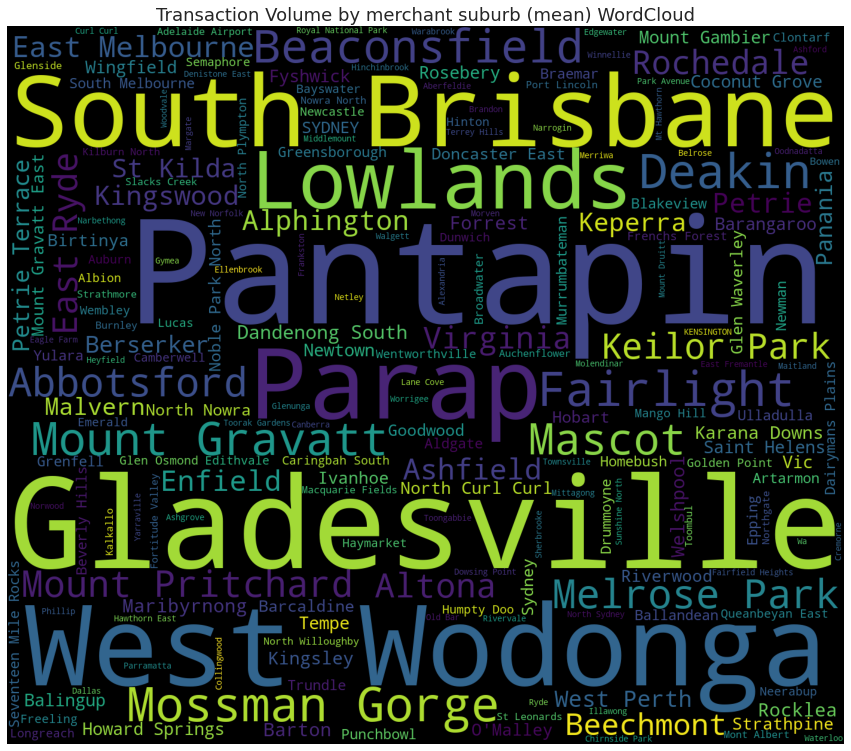

In [146]:
tuple_suburb_mean = [tuple(x) for x in merchant_suburb_mean.values]
plt.subplots(figsize=(15,15))
wordcloud2 = WordCloud(width=1400,height=1200).generate_from_frequencies(dict(tuple_suburb_mean))
plt.title('Transaction Volume by merchant suburb (mean) WordCloud')

plt.imshow(wordcloud2)
plt.axis("off")

> #### *Account balance over dates.*

In [147]:
#mean
acc_bal_mean=df.groupby(["date",'gender'])["balance"].mean().reset_index()
acc_bal_mean.head(5)

,date,gender,balance
0,2018-08-01,M,11230.392879
1,2018-08-01,F,8728.854789
2,2018-08-02,M,17043.654578
3,2018-08-02,F,10258.646232
4,2018-08-03,M,16701.198590


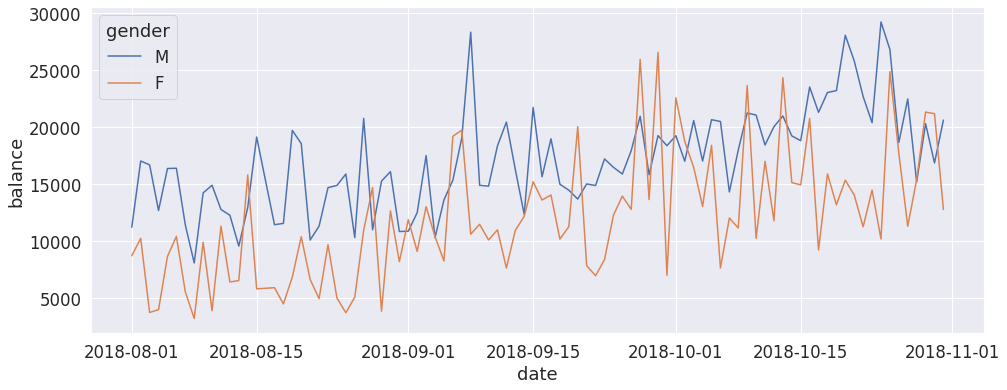

In [148]:
plt.figure(figsize=(16, 6))
sns.lineplot(y="balance",x="date",hue="gender",data=acc_bal_mean)

> ##### *Account balance (mean) for various states over dates*

In [149]:
acc_bal_state= df.groupby(['merchant_state',"gender"])["balance"].mean().reset_index()
acc_bal_state.head()

,merchant_state,gender,balance
0,ACT,M,9176.572593
1,ACT,F,14433.733913
2,NSW,M,9936.826013
3,NSW,F,8855.846765
4,NT,M,38011.864000


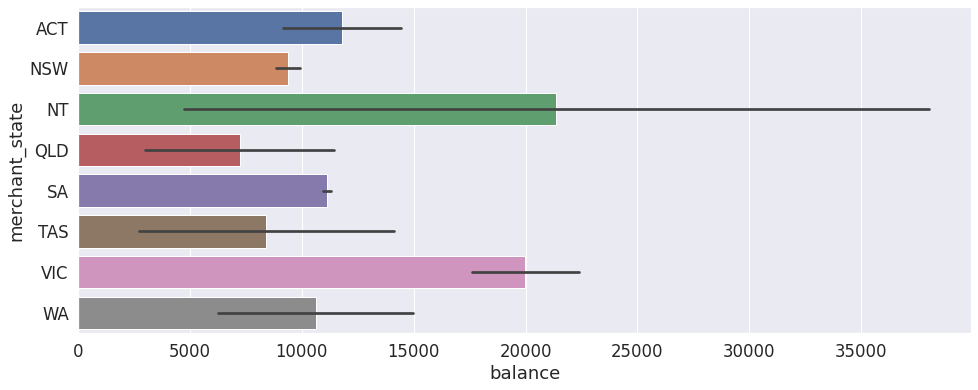

In [150]:
plt.figure(figsize=(16, 6))
sns.barplot(x="balance", y="merchant_state",  data=acc_bal_state)


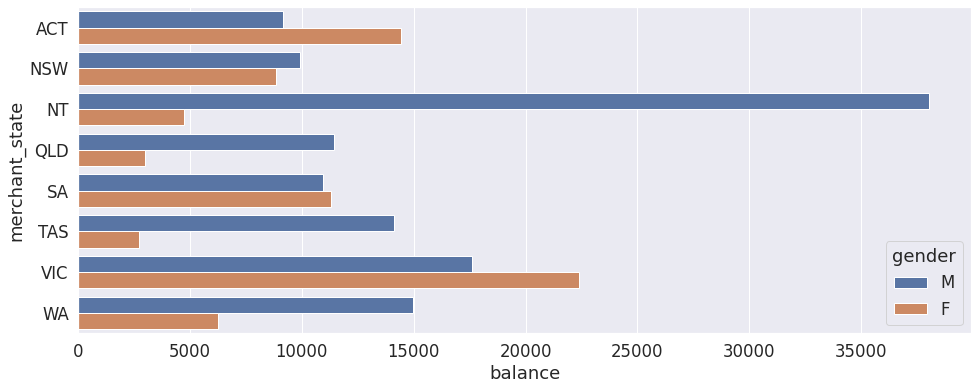

In [151]:
plt.figure(figsize=(16, 6))
sns.barplot(x="balance", y="merchant_state",hue="gender",  data=acc_bal_state)

> #### *Total and mean transaction by age*

In [152]:
#total transaction
age_amount_sum= df.groupby(['age',"gender"])["amount"].sum().reset_index()
age_amount_sum.head()

,age,gender,amount
0,18,M,34020.50
1,18,F,45124.14
2,19,M,61733.92
3,19,F,84318.80
4,20,M,67341.64


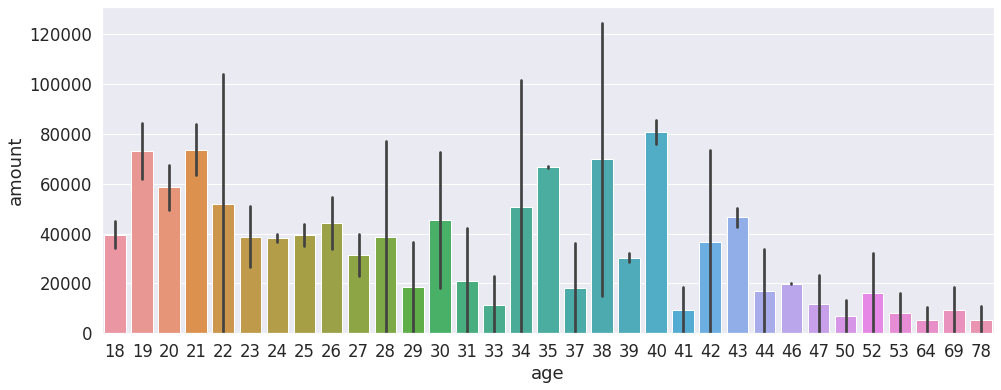

In [153]:
plt.figure(figsize=(16, 6))
sns.barplot(y="amount", x="age",  data=age_amount_sum)

In [154]:
#mean transaction
age_amount_mean= df.groupby(['age',"gender"])["amount"].mean().reset_index()
age_amount_mean.head()

,age,gender,amount
0,18,M,234.624138
1,18,F,151.933131
2,19,M,177.396322
3,19,F,244.402319
4,20,M,168.354100


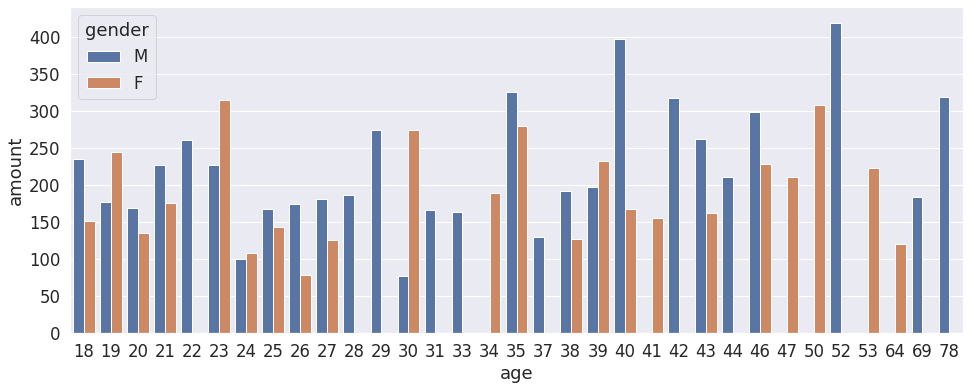

In [155]:
plt.figure(figsize=(16, 6))
sns.barplot(y="amount", x="age", hue="gender", data=age_amount_mean)

> #### *Debit-Credit transaction*

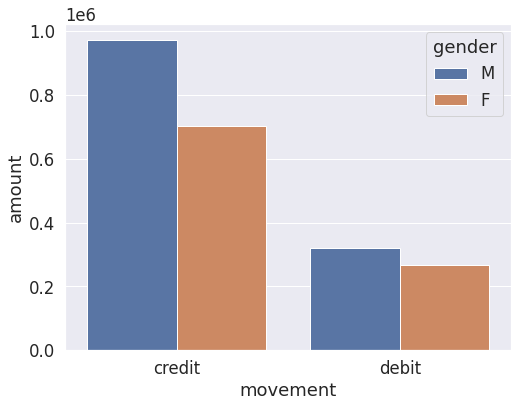

In [156]:
#Debit-Credit transaction total by gender
debit_credit_total= df.groupby(["movement","gender"])["amount"].sum().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(y="amount", x="movement", hue="gender", data=debit_credit_total)

### ***Plotting world map cooridinates***

In [157]:
df=df[["amount",'merchant_long_lat',"merchant_suburb","movement","gender"]]
df=df.dropna()
df= df.reindex(columns = df.columns.tolist() + ['long','lat'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7717 entries, 0 to 12042
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   amount             7717 non-null   float64 
 1   merchant_long_lat  7717 non-null   object  
 2   merchant_suburb    7717 non-null   object  
 3   movement           7717 non-null   object  
 4   gender             7717 non-null   category
 5   long               0 non-null      float64 
 6   lat                0 non-null      float64 
dtypes: category(1), float64(3), object(3)
memory usage: 429.7+ KB


In [158]:
longitude=[]
latitude=[]

for row in df['merchant_long_lat']:
    
    longitude.append(row.split(' ')[0])
    latitude.append(row.split(' ')[1])
    
df["long"]=longitude
df["lat"]=latitude

df.head()

,amount,merchant_long_lat,merchant_suburb,movement,gender,long,lat
0,16.25,153.38 -27.99,Ashmore,debit,F,153.38,-27.99
1,14.19,151.21 -33.87,Sydney,debit,F,151.21,-33.87
2,6.42,151.21 -33.87,Sydney,debit,M,151.21,-33.87
3,40.90,153.05 -26.68,Buderim,debit,F,153.05,-26.68
4,3.25,153.44 -28.06,Mermaid Beach,debit,F,153.44,-28.06


In [159]:
df[["long", "lat"]] = df[["long", "lat"]].apply(pd.to_numeric)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7717 entries, 0 to 12042
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   amount             7717 non-null   float64 
 1   merchant_long_lat  7717 non-null   object  
 2   merchant_suburb    7717 non-null   object  
 3   movement           7717 non-null   object  
 4   gender             7717 non-null   category
 5   long               7717 non-null   float64 
 6   lat                7717 non-null   float64 
dtypes: category(1), float64(3), object(3)
memory usage: 429.7+ KB


In [160]:
#The maximum ranges in longitude and latitude

ranges = ((df.long.min(),   df.long.max(),      
         df.lat.min(), df.lat.max()))
print(ranges)

(113.83, 153.61, -43.31, -12.33)


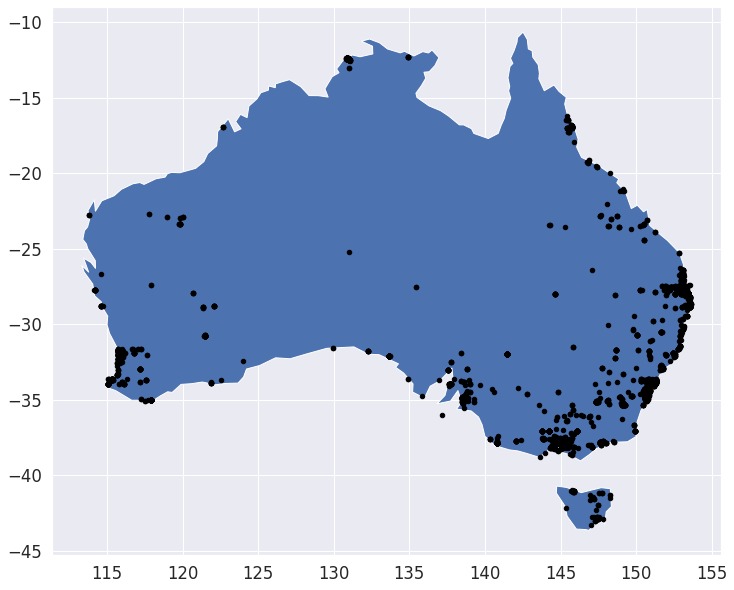

In [161]:
#Plotting the transactions over the map of australia

geometry = [Point(xy) for xy in zip(df['long'], df['lat'])]
gdf = GeoDataFrame(df, geometry=geometry)   

#selecting australia
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

aus =  world[world.name == "Australia"]

gdf.plot(ax=aus.plot(figsize=(12, 12)), marker='o', color='black', markersize=20)

In [162]:
gdf.head()

,amount,merchant_long_lat,merchant_suburb,movement,gender,long,lat,geometry
0,16.25,153.38 -27.99,Ashmore,debit,F,153.38,-27.99,POINT (153.38000 -27.99000)
1,14.19,151.21 -33.87,Sydney,debit,F,151.21,-33.87,POINT (151.21000 -33.87000)
2,6.42,151.21 -33.87,Sydney,debit,M,151.21,-33.87,POINT (151.21000 -33.87000)
3,40.90,153.05 -26.68,Buderim,debit,F,153.05,-26.68,POINT (153.05000 -26.68000)
4,3.25,153.44 -28.06,Mermaid Beach,debit,F,153.44,-28.06,POINT (153.44000 -28.06000)
